# Банки - анализ оттока клиентов
### Задача
1) Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

2) Провести исследовательский анализ данных

3) Выделить портреты клиентов, которые склонны уходить из банка

4) Сформулировать и проверить статистические гипотезы

5) Гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались

6) Статистическую гипотезу относительно представленных данных

### Описание данных
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

#### Колонки:

userid — идентификатор пользователя,

score — баллы кредитного скоринга,

City — город,

Gender — пол,

Age — возраст,

Objects — количество объектов в собственности,

Balance — баланс на счёте,

Products — количество продуктов, которыми пользуется 
клиент,

CreditCard — есть ли кредитная карта,

Loyalty — активный клиент,

estimated_salary — заработная плата клиента,

Churn — ушёл или нет.

### Материалы 
Презентация https://disk.yandex.ru/i/vGLGUFXhnOe15Q

In [1]:
%pip install plotly==5.5.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install calmap

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import plotly

import folium 
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from matplotlib.pyplot import figure, show
import calmap 

import time
from geopy.geocoders import Nominatim 

import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

In [7]:
df = pd.read_csv('/datasets/bank_dataset.csv')
cm = df.copy()

## Получим информацию о данных

In [8]:
df.head()

userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Пропуски и дубликаты

In [10]:
def draw_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
draw_missing(df)

Total  Percent
Balance            3617    36.17
userid                0     0.00
score                 0     0.00
City                  0     0.00
Gender                0     0.00
Age                   0     0.00
Objects               0     0.00
Products              0     0.00
CreditCard            0     0.00
Loyalty               0     0.00
estimated_salary      0     0.00
Churn                 0     0.00

Процент пропусков в столбце баланс не певышает 40%, с одной стороны такое количество не большое и их можно удалить, но с другой стороны пропуски могут означать 0 баланс. Оставим их на данном этапе

In [11]:
df.duplicated().sum()

0

### Анализ числовых столбцов

In [12]:
df[['score', 'Age', 'Objects', 'Products', 'Balance', 'estimated_salary' ]].describe().T

count           mean           std      min         25%  \
score             10000.0     650.528800     96.653299   350.00     584.000   
Age               10000.0      38.921800     10.487806    18.00      32.000   
Objects           10000.0       5.012800      2.892174     0.00       3.000   
Products          10000.0       1.530200      0.581654     1.00       1.000   
Balance            6383.0  119827.493793  30095.056462  3768.69  100181.975   
estimated_salary  10000.0  100090.239881  57510.492818    11.58   51002.110   

                         50%          75%        max  
score                652.000     718.0000     850.00  
Age                   37.000      44.0000      92.00  
Objects                5.000       7.0000      10.00  
Products               1.000       2.0000       4.00  
Balance           119839.690  139512.2900  250898.09  
estimated_salary  100193.915  149388.2475  199992.48

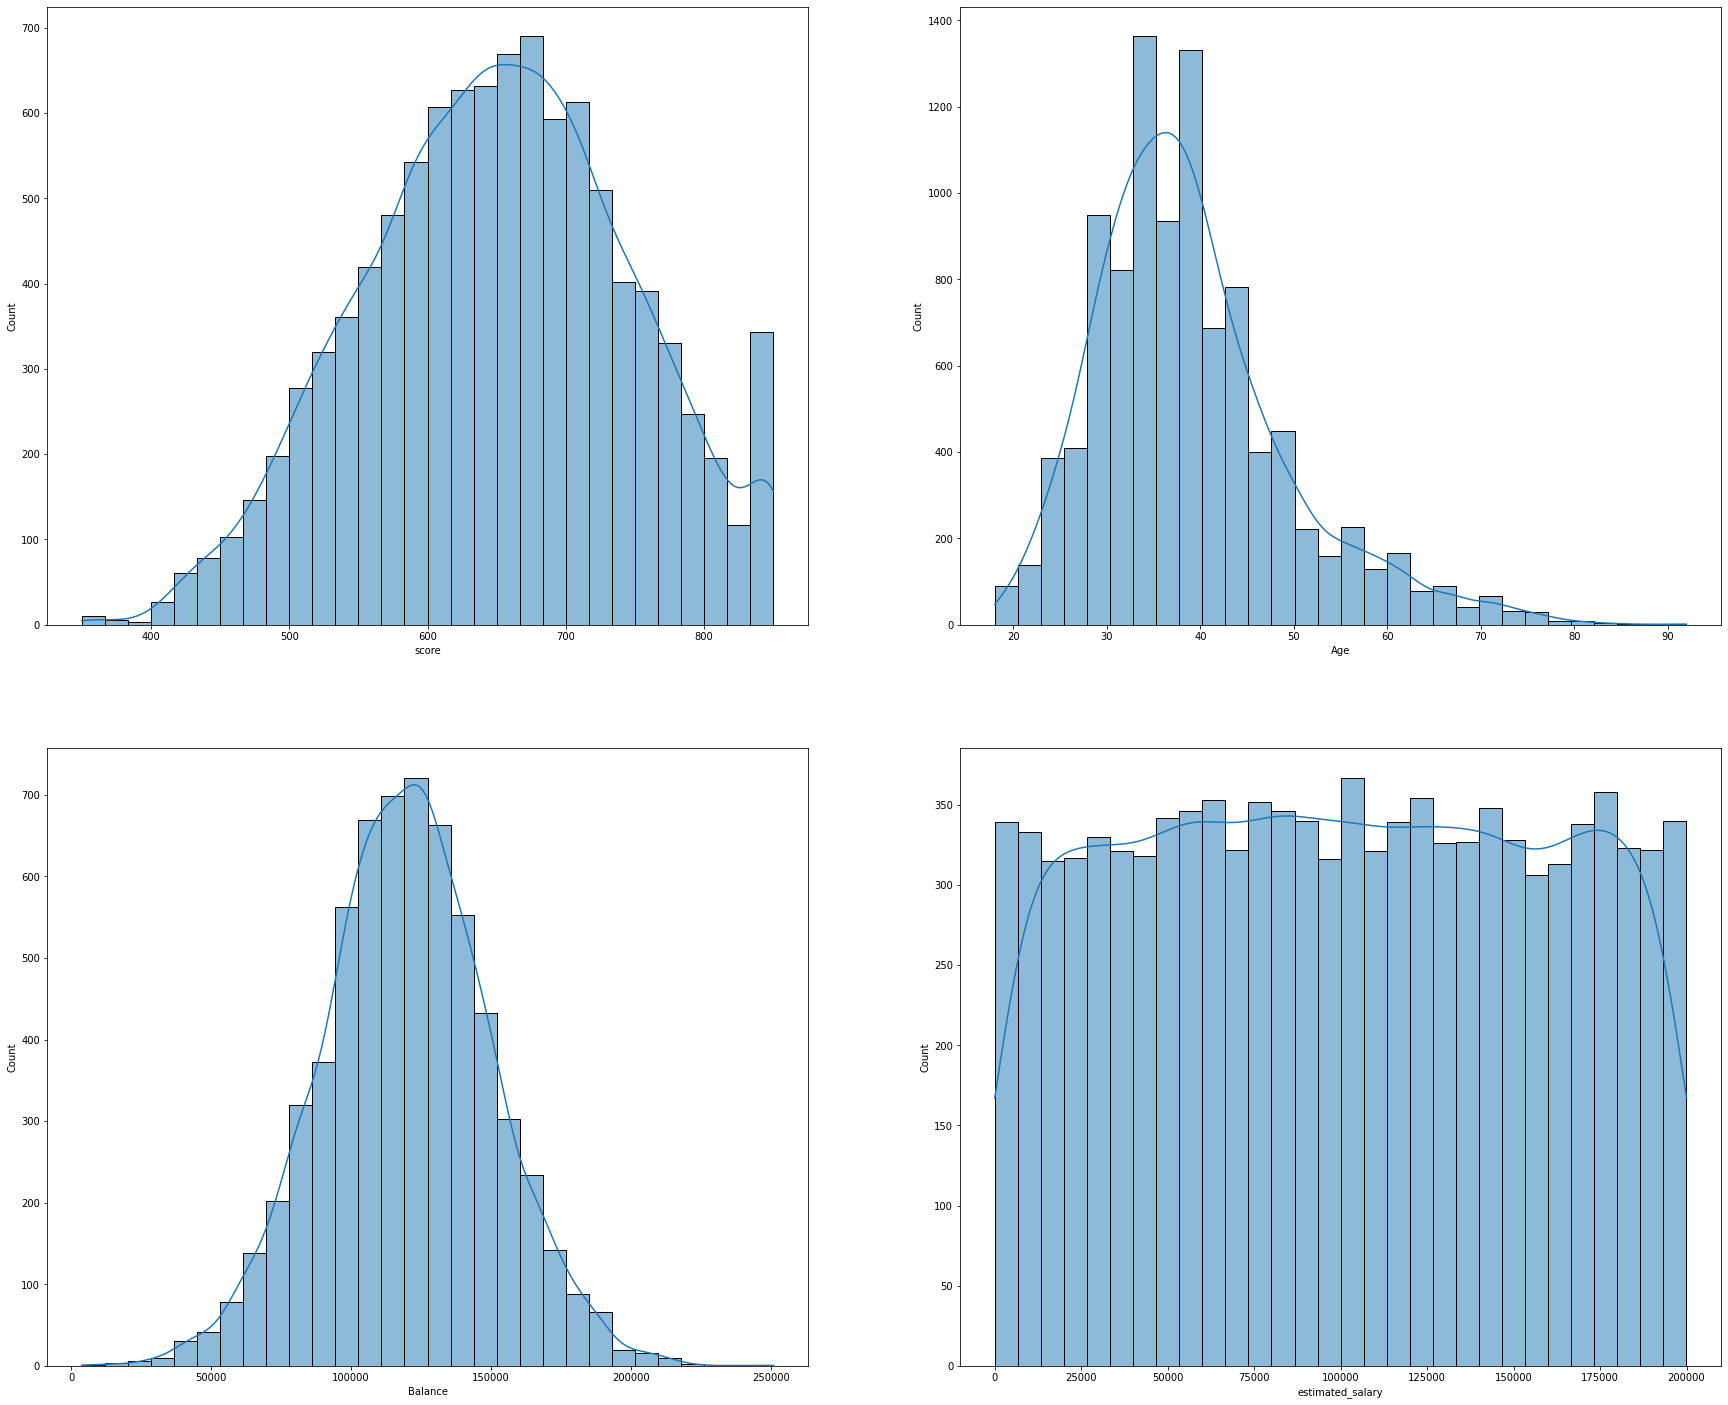

In [13]:
def hist(df, x, ax, bins=30):
    sns.histplot(data=df, x=x, bins=bins, ax=ax,kde=True)    

columns = ['score', 'Age', 'Balance', 'estimated_salary' ]

fig, axs = plt.subplots(2, 2, figsize=(30, 25))

for i, col in enumerate(columns):
    
    row_index = i // 2
    col_index = i % 2
    
    hist(df, col, axs[row_index][col_index])

plt.show()

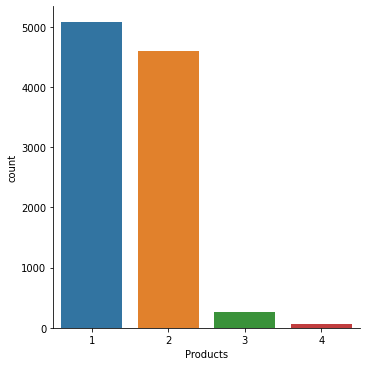

In [14]:
sns.catplot(data=df, x='Products', kind='count');

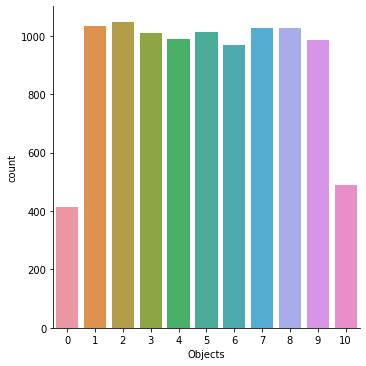

In [15]:
sns.catplot(data=df, x='Objects', kind='count');

Визуализация данных помогает нам сделать вывод: 

    1) Score: самое большое количество баллов находится в диапазоне 600 - 700

    2) Age: основной возраст клиентов 37 - 31 

    3) Objects: интересное распредление данных, количество вхождений по каждому объекту примерно равно, минимум вхождений у 0 и 10 объектов

    4) Products: в основном клиенты  преобретают не более двух дополнительных услуг банка

    5) Balance: самый частый баланс от 100000 до 150000

    6) Salary: количество вхождений по зарплате приблизительно одинаковый у всех

### Изменение типов данных

Видим, что стобцы churn, loyalty, credit card, gender - имеют категориальный характер

In [16]:
cat = ['Churn', 'Loyalty', 'CreditCard', 'Gender']
for i in cat :
    df[i] = df[i].astype('category')

In [17]:
df[['Churn', 'Loyalty', 'CreditCard', 'Gender']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Churn       10000 non-null  category
 1   Loyalty     10000 non-null  category
 2   CreditCard  10000 non-null  category
 3   Gender      10000 non-null  category
dtypes: category(4)
memory usage: 39.7 KB


### Приведем названия столбцов к нижему регистру для удобства.

In [18]:
df.columns = df.columns.str.lower()
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [19]:
cm.columns = cm.columns.str.lower()
cm.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Добавление новых столбцов
Тк в данных присутствует город, добавим информацию по широте и долготе города

In [20]:
app = Nominatim(user_agent="russia")

In [21]:
def lat(x): 
    time.sleep(1)
    try:
        return app.geocode(x).raw["lat"]
    except:
        return lat(x)   
    
def lon(x):    
    time.sleep(1)
    try:
        return app.geocode(x).raw["lon"]
    except:
        return lon(x)

In [22]:
geo = df['city'].value_counts()

In [23]:
geo = geo.to_frame().reset_index().rename(columns={"city":"count","index":"city"})

In [24]:
geo['lat'] = geo['city'].apply(lat)

In [25]:
geo['lon'] = geo['city'].apply(lon)

In [26]:
geo

city  count         lat         lon
0       Ярославль   5014  57.6263877  39.8933705
1  Ростов Великий   2509  57.1974627  39.4073138
2         Рыбинск   2477   58.050373   38.834637

In [27]:
df = pd.merge(df, geo, on="city")

In [28]:
df.head()

userid  score       city gender  age  objects    balance  products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15662040    502  Ярославль      Ж   42        8  159660.80         3   
2  15744090    699  Ярославль      Ж   39        1        NaN         2   
3  15635267    822  Ярославль      М   50        7        NaN         2   
4  15835101    501  Ярославль      М   44        4  142051.07         2   

  creditcard loyalty  estimated_salary churn  count         lat         lon  
0          1       1         101348.88     1   5014  57.6263877  39.8933705  
1          1       0         113931.57     1   5014  57.6263877  39.8933705  
2          0       0          93826.63     0   5014  57.6263877  39.8933705  
3          1       1          10062.80     0   5014  57.6263877  39.8933705  
4          0       1          74940.50     0   5014  57.6263877  39.8933705

### Обработка пропусков

In [29]:
nan = df[df['balance'].isnull()]

In [30]:
nan

userid  score       city gender  age  objects  balance  products  \
0     15677338    619  Ярославль      Ж   42        2      NaN         1   
2     15744090    699  Ярославль      Ж   39        1      NaN         2   
3     15635267    822  Ярославль      М   50        7      NaN         2   
7     15675000    476  Ярославль      Ж   34       10      NaN         2   
8     15734219    549  Ярославль      Ж   25        5      NaN         2   
...        ...    ...        ...    ...  ...      ...      ...       ...   
7482  15654074    714    Рыбинск      М   29        4      NaN         2   
7484  15609279    573    Рыбинск      М   44        9      NaN         2   
7485  15637348    702    Рыбинск      М   44        9      NaN         1   
7489  15648358    841    Рыбинск      М   28        4      NaN         2   
7490  15699841    726    Рыбинск      М   36        2      NaN         1   

     creditcard loyalty  estimated_salary churn  count         lat         lon  
0             1       1         101348.88     1   5014  57.6263877  39.8933705  
2             0       0          93826.63     0   5014  57.6263877  39.8933705  
3             1       1          10062.80     0   5014  57.6263877  39.8933705  
7             1       0          26260.98     0   5014  57.6263877  39.8933705  
8             0       0         190857.79     0   5014  57.6263877  39.8933705  
...         ...     ...               ...   ...    ...         ...         ...  
7482          1       1          37605.90     0   2477   58.050373   38.834637  
7484          1       0         107124.17     0   2477   58.050373   38.834637  
7485          0       0          59207.41     1   2477   58.050373   38.834637  
7489          1       1         179436.60     0   2477   58.050373   38.834637  
7490          1       0         195192.40     0   2477   58.050373   38.834637  

[3617 rows x 15 columns]

In [31]:
nan = df[df['balance'].isnull()]

Предположим, что речь идет об остатке на счете в конце периода. Посмотрим как связан отток клиентов и заработная плата

In [32]:
nan.churn.value_counts()

0    3117
1     500
Name: churn, dtype: int64

Заметим, что пропуски в большинстве присуще оставшимся клиентам. Посмотри, как связны пропуски и кредитные карты

In [33]:
nan.creditcard.value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

Пропуски в балансе присуще клиентам с кредитными картами

In [34]:
nan.products.value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

Пропуски в балансе присуще клиентам с двумя продуктами, напрмер это может быть ипотека и кредитная карта

In [35]:
pivot_table= nan.pivot_table(index=['products'],
                                columns = 'creditcard',
                                values = 'userid',
                                aggfunc='count')
pivot_table

creditcard    0     1
products             
1           248   657
2           742  1858
3            30    68
4             5     9

In [36]:
nan['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

In [37]:
nan.estimated_salary.describe().T

count      3617.000000
mean      98983.559549
std       57730.828955
min          90.070000
25%       49506.820000
50%       98618.790000
75%      148330.970000
max      199992.480000
Name: estimated_salary, dtype: float64

Действительно, у людей с кредитными картами и двумя продуктами больше всего пропусков.

Скорее всего всего все пропущенные значения означают нулевой баланс. 

Другой вариант, что речь идет о клиентах, использующих только кредитные продукты и не держащих собственных средств на дебетовом счете. В таком случае у клиента как раз могут быть два продукта: например, ипотека и кредитка.

Так же заметим, что пропуски в балансе только у тех, кто живет в Ярославле и Рыбинске, приемущественно в Ярославле

Стоит отметить, что в данных с попусками есть экстремально низкие число по заработной плате клиета - можно считать это выбросами.

Обработать данные пропуски без дополнительной информации невозможно


### Вывод
1) Визуализация данных помогает нам сделать вывод: 

    1.1 Score: самое большое количество баллов находится в диапазоне 600 - 700

    1.2 Age: основной возраст клиентов 37 - 31 

    1.3 Objects: количество вхождений по каждому объекту примерно равно, минимум вхождений у 0 и 10 объектов

    1.4 Products: в основном клиенты  преобретают не более двух дополнительных услуг банка

    1.5 Balance: самый частый баланс от 100000 до 150000

    1.6 Salary: количество вхождений по зарплате приблизительно одинаковый у всех
    
2) Перевели названия в нижний регистр 

3) Изменили тип данных у 'Churn', 'Loyalty', 'CreditCard', 'Gender' на категориальный 

4) Выдвинули предположение по пропускам в столбце баланса: 
    
    4.1 Нулевой баланс 
    
    4.2 Клиенты использующие кредитные карты

5) Дубликатов не обнаружино

Данные чистые, приступим к EDA

## EDA

### Корреляция данных

In [38]:
df = df.drop(columns = ['userid', 'count'], axis=1)


In [39]:
cm = cm.drop(columns = ['userid'], axis=1)

In [40]:
cm.city = cm.city.astype('category')

In [41]:
cm['city_cat'] = cm['city'].cat.codes

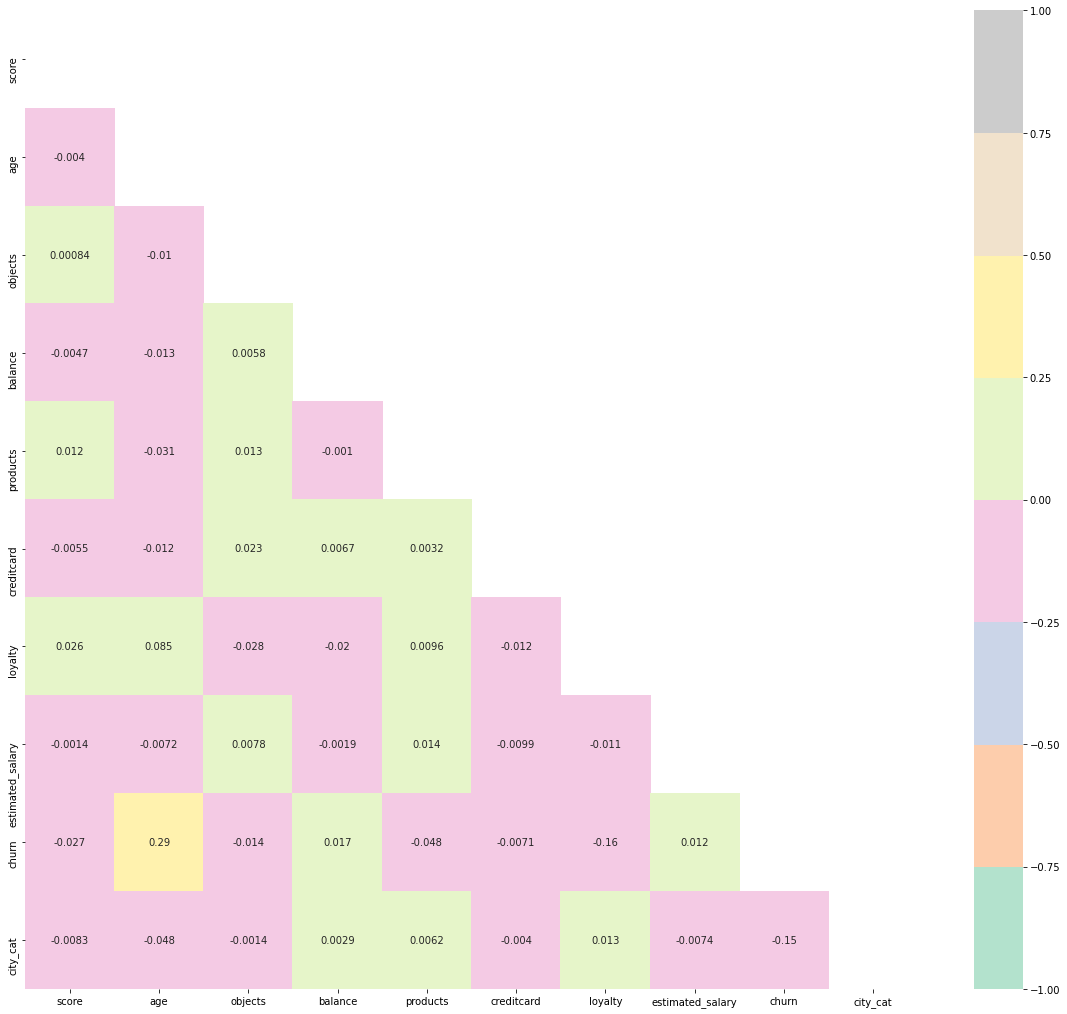

In [45]:
plt.figure(figsize = (20,18))

m =np.triu(np.ones_like(cm.corr(), dtype=bool))

sns.heatmap(cm.corr(), data = df, mask = m,  annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'Pastel2');

Данные между собой не коррелируют.

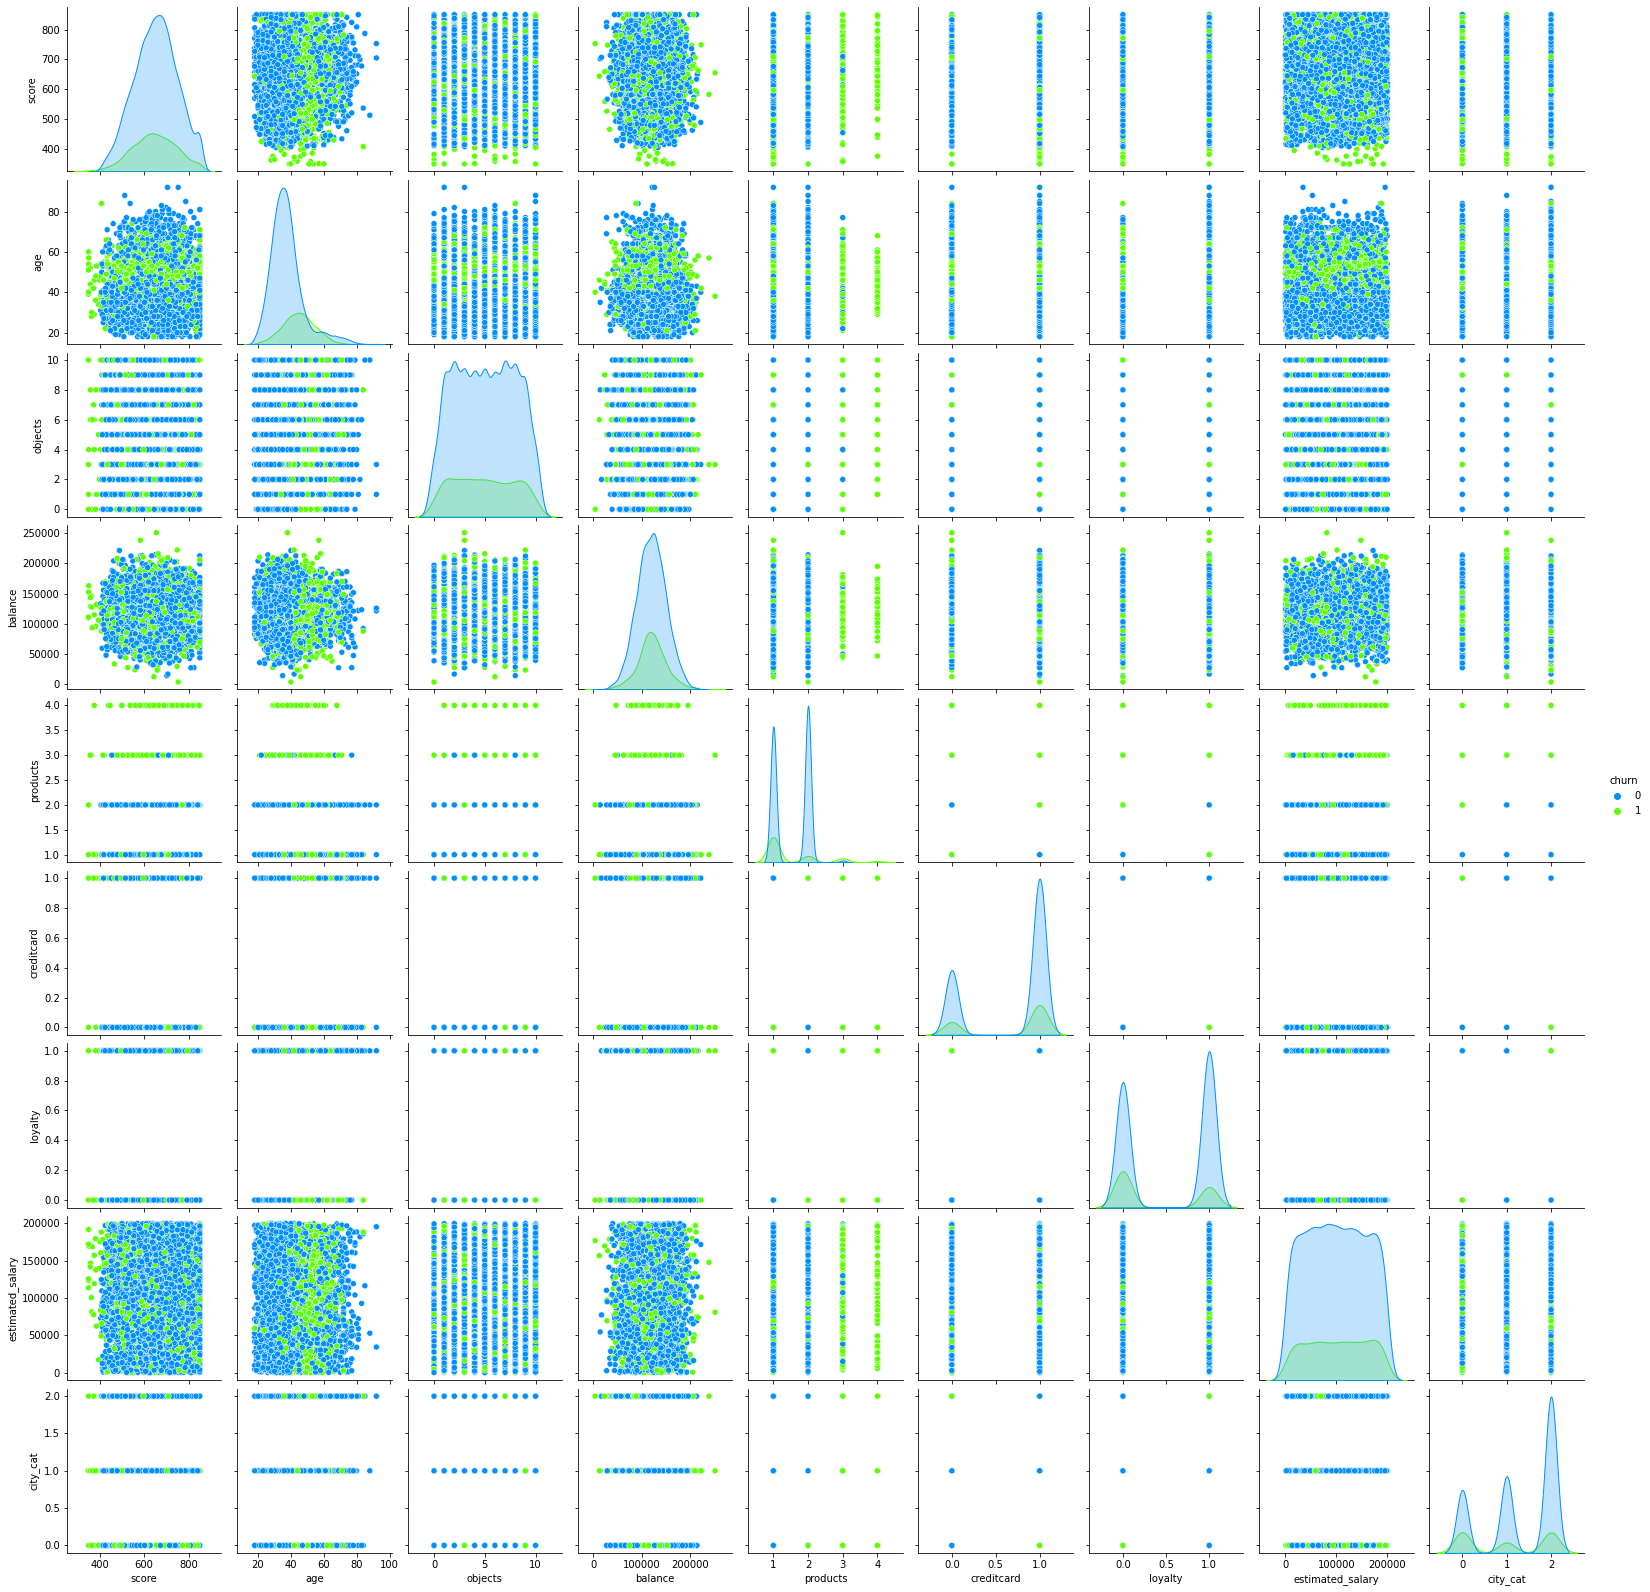

In [46]:
sns.pairplot(cm,hue= 'churn', palette="gist_rainbow_r");

### Выводы

Сильно влияющих на отток признаков на тепловой карте не наблюдается.

Больше остальных с целевой переменной коррелирует возраст клиента (age) - чем он выше, тем больше вероятность оттока.

Далее по значимости следует активность (loyalty) - менее активные клиенты с большей вероятностью перестанут пользоваться услугами банка

Пар сильно коррелирующих между собой признаков не обнаружено.

### Средние и стандартные отклонения признаков

In [47]:
data = df.copy()
data.churn = data.churn.astype(int)

In [48]:
data.churn 

0       1
1       1
2       0
3       0
4       0
       ..
9995    1
9996    0
9997    0
9998    0
9999    1
Name: churn, Length: 10000, dtype: int64

In [49]:
mean_std = data.agg(['mean', 'std']).T.round(1)
mean_std

mean      std
score                650.5     96.7
age                   38.9     10.5
objects                5.0      2.9
balance           119827.5  30095.1
products               1.5      0.6
estimated_salary  100090.2  57510.5
churn                  0.2      0.4

Средняя по:
* оттоку клиентов равна 20%
* возрасту клиентов 40

### Распределения признаков

#### Количественные признаки

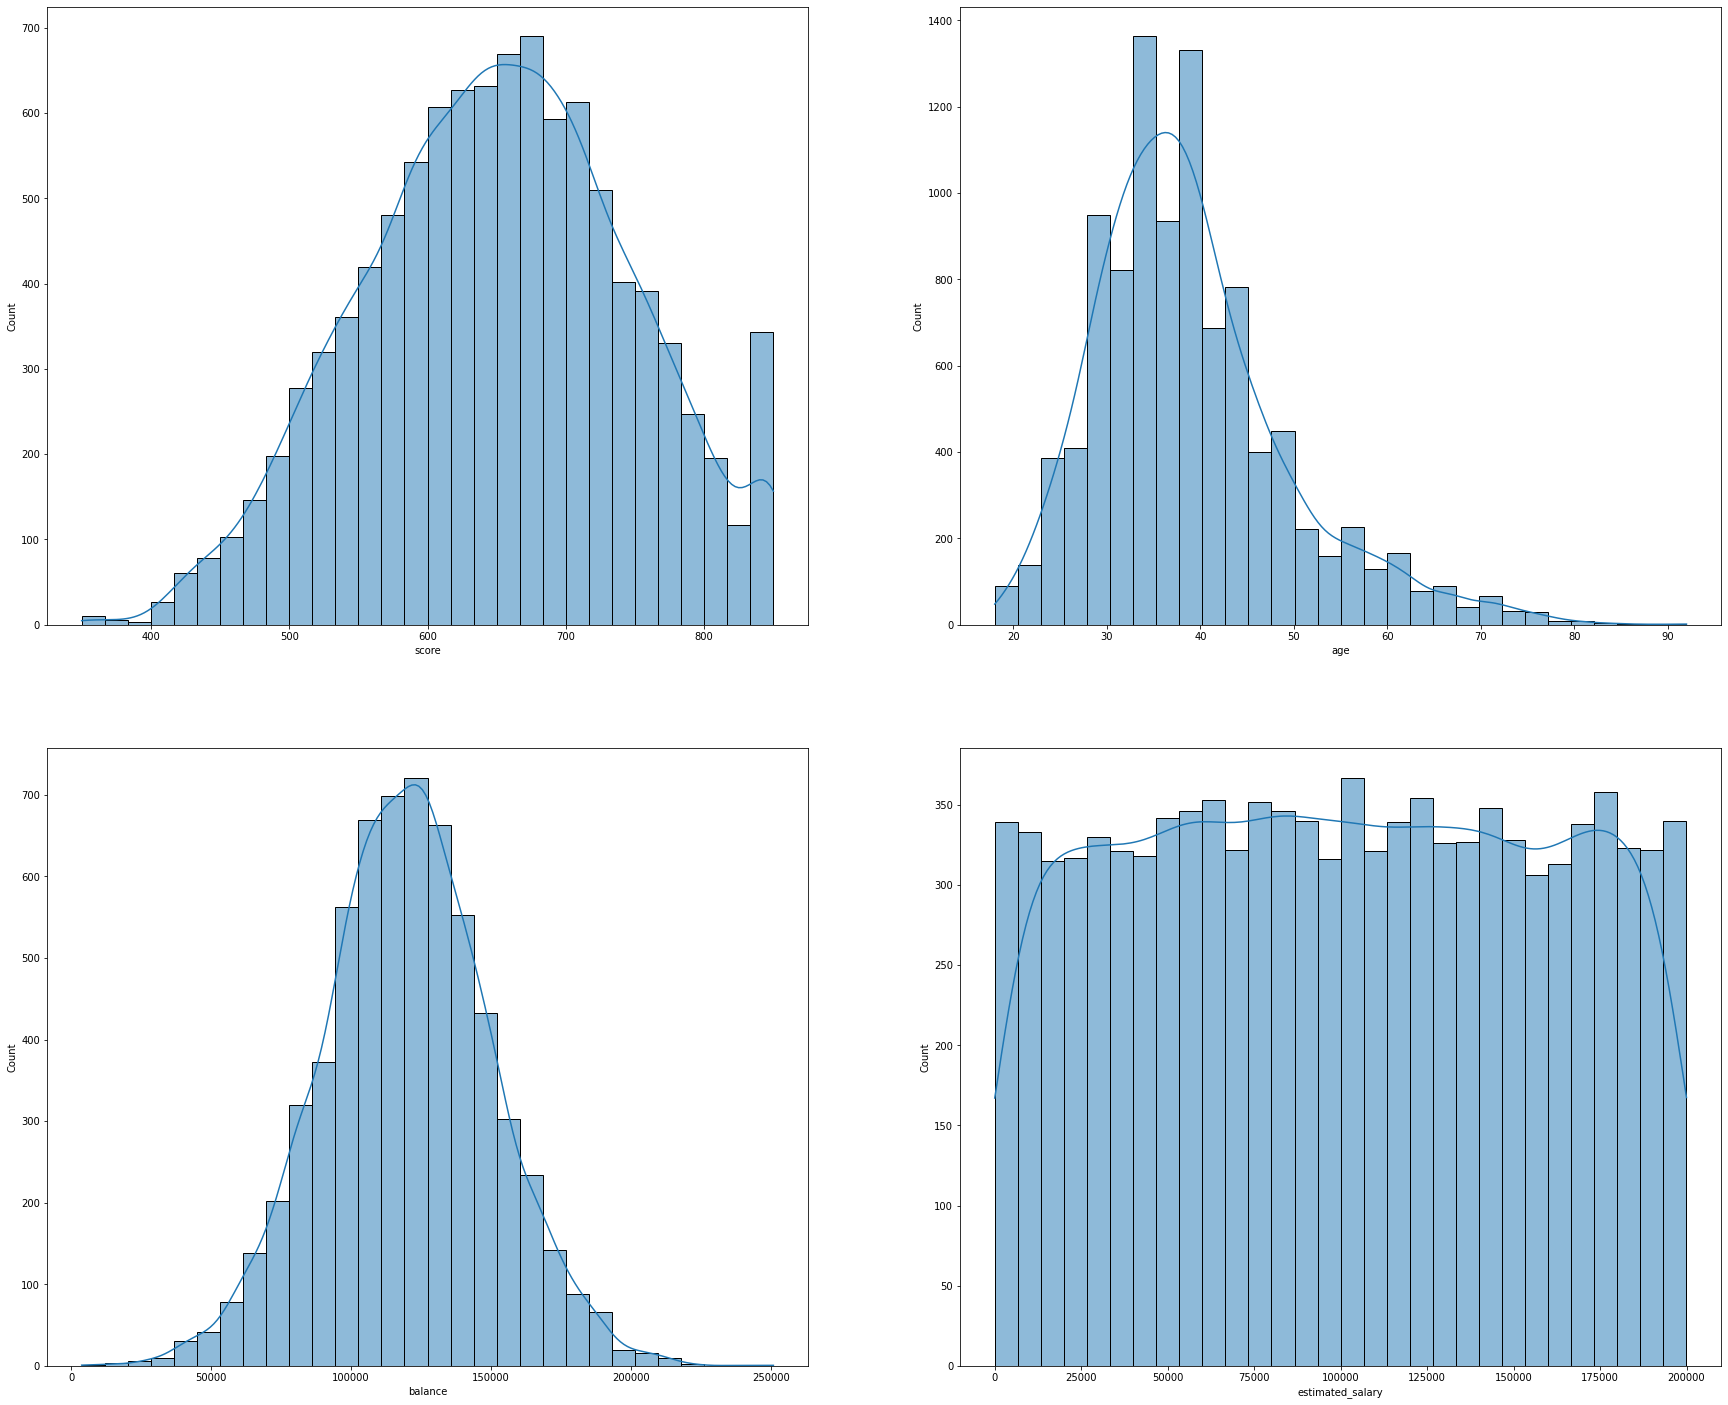

In [50]:

columns = ['score', 'age', 'balance', 'estimated_salary' ]

fig, axs = plt.subplots(2, 2, figsize=(30, 25))

for i, col in enumerate(columns):
    
    row_index = i // 2
    col_index = i % 2
    
    hist(df, col, axs[row_index][col_index])

plt.show()

    1) Score: самое большое количество баллов находится в диапазоне 600 - 700

    2) Age: основной возраст клиентов 37 - 31 

    3) Objects: интересное распредление данных, количество вхождений по каждому объекту примерно равно, минимум вхождений у 0 и 10 объектов

    4) Products: в основном клиенты  преобретают не более двух дополнительных услуг банка

    5) Balance: самый частый баланс от 100000 до 150000

    6) Salary: количество вхождений по зарплате приблизительно одинаковый у всех

Количественные признаки распределены нормально. **Из аномалий видим, что есть резкий всплеск в score на 850 величине** - это может быть связано с тем, что более выские баллы не выгодны для банка. Также удивляет переменная **с зарплатой - данные распределены равно**, нет скошенных кривых - это может быть связано с опредленной выборкой модели клиента



Скорее всего это говорит о том, что модель скоринга искусственно обрезана на значении 850, т.е. многие клиенты могли бы получить и больше, но это по каким-то причинам не целесообразно. Хвост распределения превратился во всплеск.

#### Категоральные  признаки

In [51]:
def catplot(df, x):
    sns.catplot(data=df, x=x, kind='count', palette="Pastel2")    

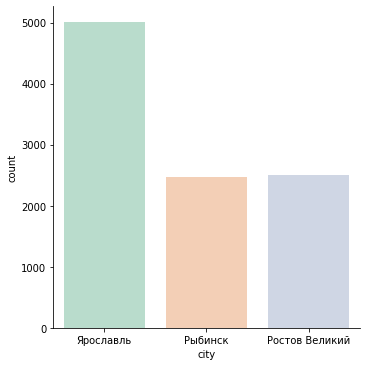

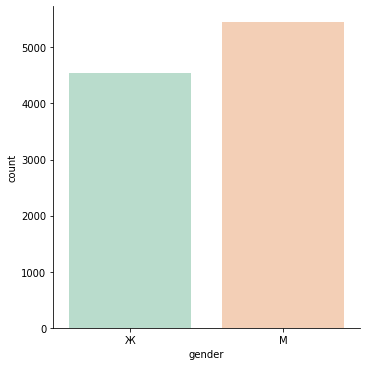

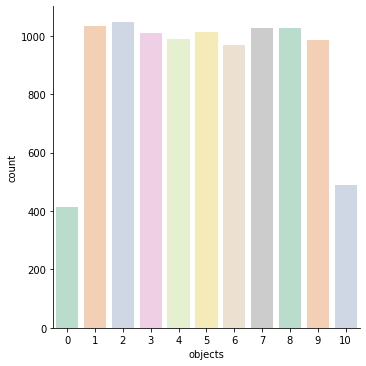

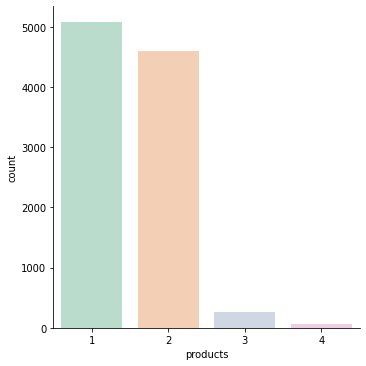

In [52]:
columns = ['city', 'gender', 'objects', 'products']

for col in columns:
    catplot(df, col)
    
plt.show()

1) Большинство людей из областного центра Ярославля. Рыбинск и Ростов примерно поровну.

2) Соотношение полов приблизительно одинаковое, но все же количество больше в пользу мужчин.

3) Странное распределение по количеству объектов: однородность у 1-9 объектов, но резкие скочки у 0 и 10 - причем они равные приблизительно, возможно это опять связно с моделью выборки 

4) Большинство клиентов пользуются одним или двумя продуктами 


#### Дискретные переменные

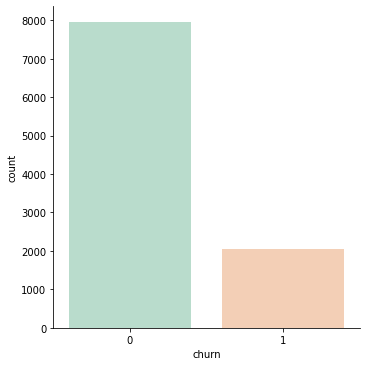

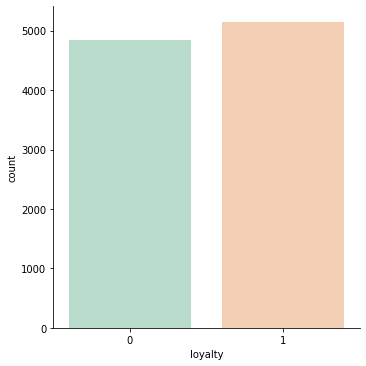

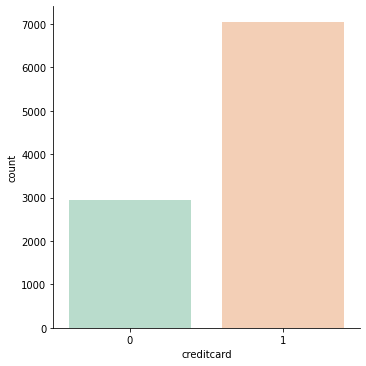

In [53]:
columns = ['churn', 'loyalty', 'creditcard']

for col in columns:
    catplot(df, col)
    
plt.show()

1) Оттока в 4 раза меньше - 20%

2) Активных клиентов примерно столько же сколько не активных 

3) Кредитными картами пользуются подавляющее большинство

### Вывод  

1) Можно отметить странную однородность распределения оценочного дохода и количества объектов в собственности. 

2) Также можно отметить скачок на максимальном кредитном скоринге

## Портреты клиентов склонных к оттоку


In [54]:
data = df.query('churn == 1 ')

### Тепловая гео-карта с районом по числу оттока 

In [55]:
%matplotlib inline
Startingmap = folium.Map(tiles='cartodbpositron', zoom_start=7)

HeatMap(data=data[['lat', 'lon']],
        radius=10).add_to(Startingmap)
Startingmap

Самый большой отток в Ярославле и Ростове, посмотрим как в числах распределены эти данные

### Категоральные и дискретные

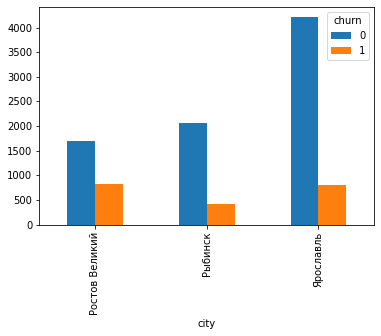

In [56]:
pd.crosstab(df.city,df.churn).plot(kind='bar');

In [57]:
data_city = df.groupby(['city','churn']).agg({'churn':["count"]})
data_city

churn
                     count
city           churn      
Ростов Великий 0      1695
               1       814
Рыбинск        0      2064
               1       413
Ярославль      0      4204
               1       810

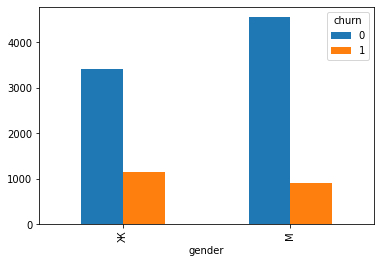

In [58]:
pd.crosstab(df.gender,df.churn).plot(kind='bar');

In [59]:
data_gen = df.groupby(['gender','churn']).agg({'churn':["count"]})
data_gen

churn
             count
gender churn      
Ж      0      3404
       1      1139
М      0      4559
       1       898

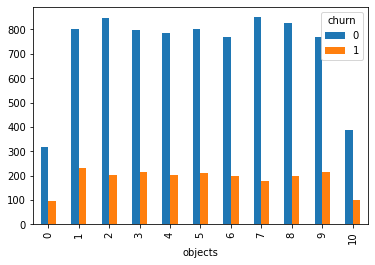

In [60]:
pd.crosstab(df.objects,df.churn).plot(kind='bar');

In [61]:
data_obj = df.groupby(['objects','churn']).agg({'churn':["count"]})
data_obj

churn
              count
objects churn      
0       0       318
        1        95
1       0       803
        1       232
2       0       847
        1       201
3       0       796
        1       213
4       0       786
        1       203
5       0       803
        1       209
6       0       771
        1       196
7       0       851
        1       177
8       0       828
        1       197
9       0       771
        1       213
10      0       389
        1       101

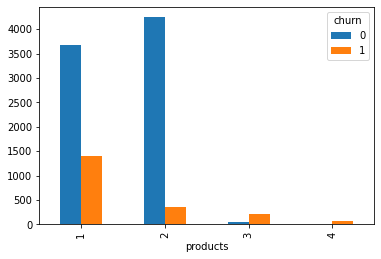

In [62]:
pd.crosstab(df.products,df.churn).plot(kind='bar');

In [63]:
data_products = df.groupby(['products','churn']).agg({'churn':["count"]})
data_products

churn
               count
products churn      
1        0      3675
         1      1409
2        0      4242
         1       348
3        0        46
         1       220
4        0         0
         1        60

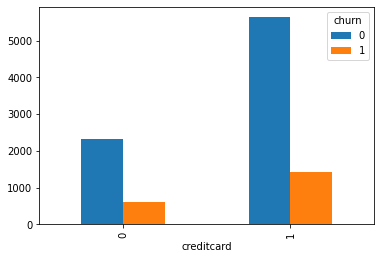

In [64]:
pd.crosstab(df.creditcard,df.churn).plot(kind='bar');

In [65]:
data_creditcard = df.groupby(['creditcard','churn']).agg({'churn':["count"]})
data_creditcard['percent'] = round(data_creditcard['churn'] / 4849 *100, 1)
data_creditcard

churn percent
                 count        
creditcard churn              
0          0      2332    48.1
           1       613    12.6
1          0      5631   116.1
           1      1424    29.4

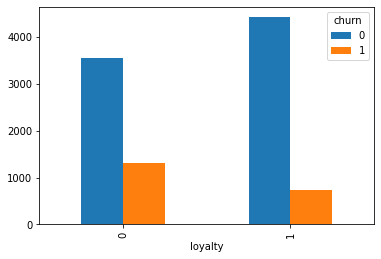

In [66]:
pd.crosstab(df.loyalty,df.churn).plot(kind='bar');

In [67]:
data_loyalty = df.groupby(['loyalty','churn']).agg({'churn':["count"]})


data_loyalty

churn
              count
loyalty churn      
0       0      3547
        1      1302
1       0      4416
        1       735

In [68]:
churn = df.query('churn == 1')

In [69]:
columns = ['loyalty', 'creditcard', 'products', 'city', 'gender']
for col in columns:
    data_all = df[col].value_counts().sort_index()
    data_churn = churn[col].value_counts().sort_index()
    percentage = round((data_churn / data_all *100)).sort_index()
    print('Процент оттока по', col )
    print(percentage)
    print()

Процент оттока по loyalty
0    27.0
1    14.0
Name: loyalty, dtype: float64

Процент оттока по creditcard
0    21.0
1    20.0
Name: creditcard, dtype: float64

Процент оттока по products
1     28.0
2      8.0
3     83.0
4    100.0
Name: products, dtype: float64

Процент оттока по city
Ростов Великий    32.0
Рыбинск           17.0
Ярославль         16.0
Name: city, dtype: float64

Процент оттока по gender
Ж    25.0
М    16.0
Name: gender, dtype: float64



#### Вывод 

**Процент оттока по лояльности:**

    не лояльный    27%
    лояльный    14%

**Процент оттока по наличию кредитной карты:**

    нет кредитной карты    21%
    есть крединтая карта    20%

**Процент оттока по количеству продуктов:**

    1 продукт     28%
    2 продукта      8%
    3 продукта     83%
    4 продукта   100%

**Процент оттока по городу проживания:**

    Ростов Великий    32%
    Рыбинск          17%
    Ярославль         16%

**Процент оттока по полу:**

    Ж    25%
    М    16%

1) Самый большой отток наблюдается в Ростове Великом **814** , а самый низкий в Рыбинске **413**

2) Женщины больше подвережны к уходу из банка: **1139** женщин на **898** мужчин

3) Самый большой отток среди клиентов, у который по **1 объекту**, хотя говорить, что разница с количеством по другим объектам - нельзя, ощутимая разница только с **0 и 10 объектами**

4) Интересный факт самый большой отток в процентном соотношении - **100% (на 60 ушедших 0 оставшихся)**, у клиентом с 4 продуктами, дальше идут те, у кого **3 продукта 220:46 ~ 1:5**. **Самый большой** отток по количеству у тех, у кого по **1 продукту**. Минимальный отток у клиентов с 2 продуктами

5) Количество оттока **больше** у тех, кто пользуется **кредитными картами**. Но если смотреть в процентном соотношении, то разница всего в 1%

6) Количество оттока **больше** у **нелояльных клиентов**


### Количественные переменные

In [70]:
df.columns

Index(['score', 'city', 'gender', 'age', 'objects', 'balance', 'products',
       'creditcard', 'loyalty', 'estimated_salary', 'churn', 'lat', 'lon'],
      dtype='object')

In [71]:
def dist(x,color = None,data=df, log = False,  nbins=None ): 
    fig = px.histogram(data, x=x, color=color, log_y=log,  nbins= nbins )
    fig.show()

In [72]:
dist('score', 'churn')

In [73]:
dist('age', 'churn')

In [74]:
dist('balance', 'churn')

In [75]:
dist('estimated_salary', 'churn')

#### Вывод 
Видим, что есть довольно заметные различия по параметру возраст в распределении ушедших и оставшихся клиентов. Границей является возраст **около 40 лет**. После 40 клиенты начинают уходить чаще. Можно предположить, что банк политика банка направлена больше на молодых людей 

Немного чаще уходят люди с остатками на счете **от 100 до 150 тыс, а также больше 200 тыс.**

In [76]:
def age_cat (df):
    if df['age'] <35 :
        return 'young adult'
    elif df['age'] >= 35 and df['age'] <= 50:
        return 'adult'
    else:
        return 'old'

    
df['age_cat'] = df.apply(age_cat, axis = 1)

In [77]:
main = df.groupby([ 'gender','age_cat', 'churn']).agg({'churn': 'count'}).rename(columns = {'churn': 'count'}).reset_index()

st = {0: "Остался", 1: "Ушел"}

main['churn'] = main['churn'].map(st)

fig = px.sunburst(main, path = ['churn','gender','age_cat'], values = 'count', color = 'churn', title = '',
                 color_discrete_map = {"Остался": '#1092c9', "Ушел": '#c91010'},
                width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

1) Чаще всего уходят женщины возраста старше 35 лет, а остаются мужчины старше 35 лет 

In [78]:
def salary_cat (df):
    if df['estimated_salary'] <60000 :
        return 'low salary'
    elif df['estimated_salary'] >= 60000 and df['estimated_salary'] <= 150000:
        return 'normal salary'
    else:
        return 'high salary'

    
df['salary_cat'] = df.apply(salary_cat, axis = 1)

In [79]:
main = df.groupby([ 'gender','salary_cat', 'churn']).agg({'churn': 'count'}).rename(columns = {'churn': 'count'}).reset_index()

st = {0: "Остался", 1: "Ушел"}

main['churn'] = main['churn'].map(st)

fig = px.sunburst(main, path = ['churn','gender','salary_cat'], values = 'count', color = 'churn', title = '',
                 color_discrete_map = {"Остался": '#1092c9', "Ушел": '#c91010'},
                width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

2) Чаще всего уходят женщины с заработной платой от 60 тысяч рублей до 150 тысяч рублей

In [80]:
def score_cat (df):
    if df['score'] <400 :
        return 'low score'
    elif df['score'] >= 400 and df['score'] <= 700:
        return 'normal score'
    else:
        return 'high score'

    
df['score_cat'] = df.apply(score_cat, axis = 1)

In [81]:
main = df.groupby([ 'gender','score_cat', 'churn']).agg({'churn': 'count'}).rename(columns = {'churn': 'count'}).reset_index()

st = {0: "Остался", 1: "Ушел"}

main['churn'] = main['churn'].map(st)

fig = px.sunburst(main, path = ['churn','gender','score_cat'], values = 'count', color = 'churn', title = '',
                 color_discrete_map = {"Остался": '#1092c9', "Ушел": '#c91010'},
                width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

3) Интересно заметить, что среди ушедших мужчин и женщин маленький процент среди ушедших с низким крединым скорингом

In [82]:
def balance_cat (df):
    if df['balance'] <50000 :
        return 'low balance'
    elif df['balance'] >= 50000 and df['balance'] <= 150000:
        return 'normal balance'
    else:
        return 'high balance'

    
df['balance_cat'] = df.apply(balance_cat, axis = 1)


In [83]:
main = df.groupby([ 'gender','balance_cat', 'churn']).agg({'churn': 'count'}).rename(columns = {'churn': 'count'}).reset_index()

st = {0: "Остался", 1: "Ушел"}

main['churn'] = main['churn'].map(st)

fig = px.sunburst(main, path = ['churn','gender','balance_cat'], values = 'count', color = 'churn', title = '',
                 color_discrete_map = {"Остался": '#1092c9', "Ушел": '#c91010'},
                width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

In [84]:
main = df.groupby([ 'salary_cat', 'balance_cat', 'score_cat', 'churn']).agg({'churn': 'count'}).rename(columns = {'churn': 'count'}).reset_index()

st = {0: "Не ушел", 1: "Ушел"}

main['churn'] = main['churn'].map(st)

fig = px.sunburst(main, path = ['churn','salary_cat', 'balance_cat', 'score_cat'], values = 'count', color = 'churn', title = '',
                 color_discrete_map = {"У него не было инсульта": '#1092c9', "Был инсульт": '#c91010'},
                width = 700, height = 700)

fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', title_font_size = 22, title_x = 0.5)

fig.update_traces(textinfo = 'label + percent parent')
                  
fig.show()

#### Вывод 
По данным отлично видно процентное соотношение ушедших и оставшихся, можно сформулировать цепочку закономерностей, по тем, кто ушел: **женщины в возрасте старше 35 с зарплатой в интервале от 60000 до 15000 рублей с балансам от 50000 до 150000 и баллами от 400 до 700**

### Вывод 

**Клиент склонен к оттоку:**: 

    Проживает в Ростове Великом
    Женщина
    Старше 40
    Использует 3 или 4 продукта
    Нелояльна
    Владеет 0-1 объектом собственности
    Остаток на счете от 100 до 150 тыс. или больше 200 тыс.

**Клиент склонен остаться:**

    Проживает в Ярославле или Рыбинске
    Мужчина
    Моложе 40
    Использует 1 - 2 продукта
    Лоялен
    В собственности больше 2 объекта
    Остаток от 75 до 100 тыс или от 150 до 200 тыс.


## Гипотезы.

### Проверим зависит ли выбор клиента: уйти или остаться от дискреных переменных

**Хи -квадрат тест независимостииспользуется, чтобы определить, существует ли значительная связь между двумя категориальными переменными.**

Переведем все категориальные данные в тип категория, что бы выявить существует ли значительная связь между оттоком клиента и переменной.

In [85]:
df.columns

Index(['score', 'city', 'gender', 'age', 'objects', 'balance', 'products',
       'creditcard', 'loyalty', 'estimated_salary', 'churn', 'lat', 'lon',
       'age_cat', 'salary_cat', 'score_cat', 'balance_cat'],
      dtype='object')

In [86]:
col = ['objects','products', 'age_cat', 'salary_cat', 'score_cat',
       'balance_cat' ]
for i in col:
    df[i] = df[i].astype('category')

In [87]:
data = df.select_dtypes(['category']).drop(columns=['churn']).columns

Выбор клиента относительно ухода из банка зависит от gender 


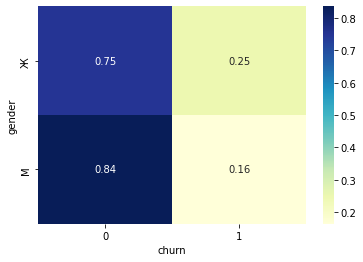

Выбор клиента относительно ухода из банка не зависит от objects 


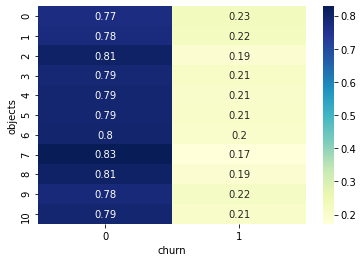

Выбор клиента относительно ухода из банка зависит от products 


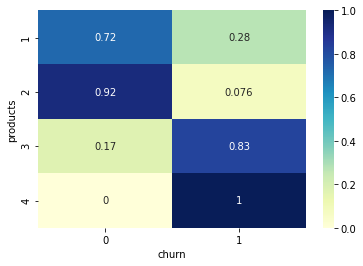

Выбор клиента относительно ухода из банка не зависит от creditcard 


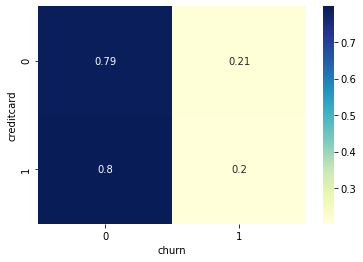

Выбор клиента относительно ухода из банка зависит от loyalty 


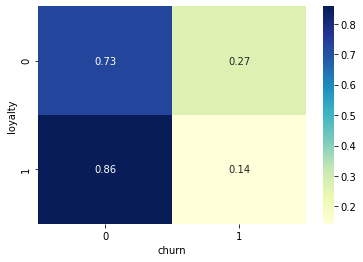

Выбор клиента относительно ухода из банка зависит от age_cat 


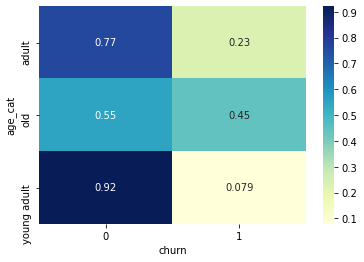

Выбор клиента относительно ухода из банка не зависит от salary_cat 


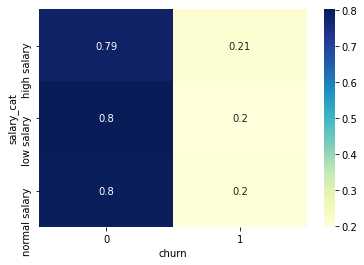

Выбор клиента относительно ухода из банка зависит от score_cat 


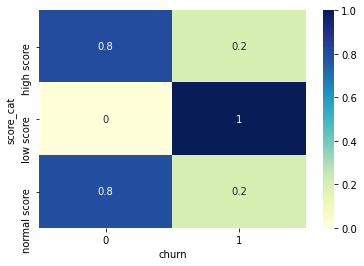

Выбор клиента относительно ухода из банка зависит от balance_cat 


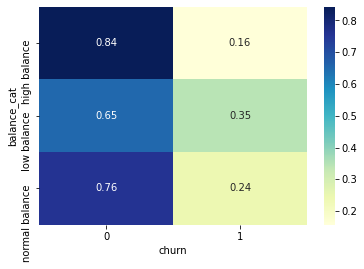

In [88]:
for i in data:
    p =  (chi2_contingency(pd.crosstab(df[i], df['churn']))[1])
    if p < .001 :
        print('Выбор клиента относительно ухода из банка зависит от {} '.format(i))
    else :
        print('Выбор клиента относительно ухода из банка не зависит от {} '.format(i))

    contigency_pct = pd.crosstab(df[i], df['churn'], normalize='index')
    sns.heatmap(contigency_pct, annot=True, cmap="YlGnBu")
    plt.show()

По результатам теста мы пришли к выводу, что выбор клиента относительно ухода из банка **зависит от его гендера** и как мы вяснили ранее чаще всего уходят женщины и от **лояльности**, чаще всего уходят не лояльные, **возрастной категории**, чаще всего уходят 40+. Так же интересно, что от категорий **кредитного скоринга и категорий баланса** также зависит выбор клиета, а вот **от наличия крединой карты, количества продуктов, категории заработной платы или объектов - не зависит**

### Гипотеза о различии дохода клиентов, которые остались и которые ушли в отток.

**Будем проверять нашу гипотезу при помощи теста Манна-Уитни, т.к у нас почти одинаковые формы распределения.** - причина выбора

*H0: Между группами "ушел" и "остался" нет статистически значимого различия доходов*

*H1: Между группами есть статистически значимое различие доходов*

α = 0.05

In [89]:
churn = df.query('churn == 1')

In [90]:
no_churn = df.query('churn == 0')

In [91]:
import scipy
a = .05
pvalue = scipy.stats.mannwhitneyu(churn['estimated_salary'], no_churn['estimated_salary']).pvalue

print("pvalue = {0:.15f}".format(pvalue))

if (pvalue < a):
    print('Статистически значимая разница')
else:
    print('Нет статистически значимой разницы')


pvalue = 0.227051509301538
Нет статистически значимой разницы


Видим, что получили довольно высокое p-значение, которое не позволило нам отвергнуть нуль-гипотезу при 5% уровне значимости.

Таким образом, мы **не можем утверждать, что между группами ушедших и оставшихся клиентов есть статистически значимые различия доходов.** 

### Вывод 

1) Выбор клиента относительно ухода из банка **зависит от его гендера** и как мы вявснили ранее чаще всего уходят женщины и от **лояльности**, чаще всего уходят не лояльные, а вот **от наличия крединой карты, количества продуктов или объектов - не зависит**

2) Мы **не можем утверждать, что между группами ушедших и оставшихся клиентов есть статистически значимые различия доходов.**

## Общий вывод 

**1. Три  признака оттока:**

    1.1 Нелояльный клиент 

    1.2 Возраст - старше 40

    1.3 Пол - женский

**2. Самый сильный отток среди клиентов из Ростова, а самый слабый в Рыбинске**

3.К оттоку оказались наиболее склонны **женщины в возрасте старше 35 с зарплатой в интервале от 60000 до 15000 рублей с балансам от 50000 до 150000 и баллами от 400 до 700**тыс.

**4. Гипотезы**:

   4.1 Гипотеза о статистически значимом различии дохода клиентов, которые ушли, и тех, которые остались, не подтвердилась.

   4.2 По результатам теста мы пришли к выводу, что выбор клиента относительно ухода из банка **зависит от его гендера** и как мы вяснили ранее чаще всего уходят женщины и от **лояльности**, чаще всего уходят не лояльные, **возрастной категории**, чаще всего уходят 40+. Так же интересно, что от категорий **кредитного скоринга и категорий баланса** также зависит выбор клиета, а вот **от наличия крединой карты, количества продуктов, категории заработной платы или объектов - не зависит**
    
    
## Рекомендации 

* Стоит подробно исследовать филиал в Ростове Великом. 

* Приоритезировать работу с населением до 40 лет. С другой стороны, исследовать причины увеличения оттока среди старшего населения и принять меры.

* Стоит разработать программы для удержания клиентов старшего возраста, причем разделить их по гендеру: пранализировать, что интересно мужчинам, что бы сохронить высокий процент ужержания клиента и женщинам, чтобы уменьшить их процент оттока. Предлагается провести маркетинговые акции с крупными сетевыми магазинами (преимущественно продуктовыми): программы кэшбэка, начисление пользовательских баллов, розыгрышами призов.

* Разработать комплекс мер для увеличения лояльности женского населения, понять, чем их можно удержать, что их не устраивает.

* Посмотреть на модель оценки заработной платы, понять почему получается однородное распределение. То же самое касается количества объектов в собственности. Проверить методы сбора информации